In [75]:
import argparse
import numpy as np
import pinocchio
from mim_control_cpp import (
    CentroidalImpedanceController
)
# %matplotlib notebook
# %matplotlib inline
import matplotlib.pylab as plt
from bullet_utils.env import BulletEnvWithGround
from robot_properties_solo.solo12wrapper import Solo12Robot, Solo12Config

import time

plt.rcParams['figure.dpi'] = 180  # makes plots bigger, default = 72.0

In [2]:
# Create a Pybullet simulation environment
env = BulletEnvWithGround()

# Create a robot instance in the simulator.
robot = Solo12Robot()
robot = env.add_robot(robot)
robot_config = Solo12Config()
mu = 0.2
kc = np.array([200, 200, 200])
dc = np.array([50, 50, 50])
kb = np.array([100, 100, 200])
db = np.array([50.0, 50.0, 200.0])
qp_penalty_weights = np.array([5e5, 5e5, 5e5, 1e6, 1e6, 1e6])

# impedance gains
kp = np.array([200, 200, 200, 0, 0, 0])
kd = np.array([10.0, 10.0, 10.0, 0, 0, 0])

pin_robot = robot.pin_robot

q_init = robot_config.q0.copy()
q_init[0] = 0.

In [86]:
ctrl = CentroidalImpedanceController()
ctrl.initialize(
    2.5,
    np.diag(robot.pin_robot.mass(q_init)[3:6, 3:6]),
    pin_robot.model,
    "universe",
    robot_config.end_effector_names,
    mu,
    qp_penalty_weights,
    kc, dc, kb, db,
    kp, kd
)

# Desired center of mass position and velocity.
x_com = [0.0, 0.0, 0.25]
xd_com = [0.0, 0.0, 0.0]
# The base should be flat.
x_ori = [0.0, 0.0, 0.0, 1.0]
x_angvel = [0.0, 0.0, 0.0]

# Desired leg length
x_des = [
     0.195,  0.147, 0.015, 0, 0, 0, 1.,
     0.195, -0.147, 0.015, 0, 0, 0, 1.,
    -0.195,  0.147, 0.015, 0, 0, 0, 1.,
    -0.195, -0.147, 0.015, 0, 0, 0, 1.
]
# x_des = np.array([
#      0.195,  0.147, 0.015, 0, 0, 0, 1.,
#      0.195, -0.147, 0.015, 0, 0, 0, 1.,
#     -0.195,  0.147, 0.015, 0, 0, 0, 1.,
#     -0.195, -0.147, 0.015, 0, 0, 0, 1.
# ])

xd_des = np.zeros(4 * 6)

dur = 0.

contact_array = np.ones(4)

      
targets = np.empty((1000, 4))
i_targets = -1

def contact_map(n):
    # interpolation
    global contact_array, x_des, targets, i_targets
    
    contact_duration = 250
    overlap_duration = 50
    initial_duration = 50  
    up, down = x_com[2]/2 , 0.015    
    
    points = (0, 
              contact_duration - overlap_duration, 
              contact_duration, 
              2 * contact_duration - overlap_duration,
              2 * contact_duration
             )
    
    if n < initial_duration:
        contact_array = np.ones(4)
        x_des[2::7] = (down, down, down, down)    
    elif (n - initial_duration) % (2 * contact_duration) == points[0]:
        contact_array = np.array((1, 0, 0, 1))
        targets = np.linspace(x_des[2::7], (down, up, up, down), num=points[1] - points[0])
#         x_des[2::7] = (down, up, up, down)    
    elif (n - initial_duration) % (2 * contact_duration) == points[1]:
        contact_array = np.ones(4)
        targets = np.linspace(x_des[2::7], (down, down, down, down), num=points[2] - points[1])
#         x_des[2::7] = (down, down, down, down)
    elif (n - initial_duration) % (2 * contact_duration) == points[2]:
        contact_array = np.array((0, 1, 1, 0))
        targets = np.linspace(x_des[2::7], (up, down, down, up), num=points[3] - points[2])
#         x_des[2::7] = (up, down, down, up)
    elif (n - initial_duration) % (2 * contact_duration) == points[3]:
        contact_array = np.ones(4)
        targets = np.linspace(x_des[2::7], (down, down, down, down), num=points[4] - points[3])
#         x_des[2::7] = (down, down, down, down)

    if i_targets >= targets.shape[0]:
        i_targets = 0
    
    x_des[2::7] = targets[i_targets]
    i_targets += 1
    
        
# def contact_map(n):
#     # not interpolation
#     global contact_array, x_des
    
#     up, down = x_com[2]/2 , 0.015
    
#     contact_duration = 250
#     overlap_duration = 50
#     initial_duration = 50
    
#     if n < initial_duration:
#         contact_array = np.ones(4)
#         return
    
    
#     if (n - initial_duration) % (2 * contact_duration) == 0:
#         contact_array = np.array((1, 0, 0, 1))
#         x_des[2::7] = (down, up, up, down)
#         return
    
#     if (n - initial_duration) % (2 * contact_duration) == contact_duration - overlap_duration:
#         contact_array = np.ones(4)
#         x_des[2::7] = (down, down, down, down)
#         return
        
#     if (n - initial_duration) % (2 * contact_duration) == contact_duration:
#         contact_array = np.array((0, 1, 1, 0))
#         x_des[2::7] = (up, down, down, up)
#         return
        
#     if (n - initial_duration) % (2 * contact_duration) == (2 * contact_duration - overlap_duration):
#         contact_array = np.array((1, 1, 1, 1))
#         x_des[2::7] = (down, down, down, down)
#         return
    
        

In [44]:
N = 4000

grfs = np.empty((N, 4, 3))
contact = np.empty((N, 4))
contact_hardcoded = np.empty((N, 4))

thresholds = np.empty(N)

qs = np.empty((N, 19))
dqs = np.empty((N, 18))

forwardKs = np.empty((N, 4, 3))

In [87]:
robot.reset_state(q_init, robot_config.v0)

In [88]:
# Run the simulator for N steps
contact_status = np.ones(4)

for n in range(N):
    # Read the final state and forces after the stepping.
    q, dq = robot.get_state()
    dqs[n] = dq.copy()
    qs[n] = q.copy()

    quat = pinocchio.Quaternion(q[6], q[3], q[4], q[5])
    quat.normalize()

    thresholds[n] = np.sum(grfs[n-1, :, 2][grfs[n-1, :, 2] > 0])

    contact[n] = np.where(grfs[n-1, :, 2] > 1, 1., 0.)

    contact_hardcoded[n] = contact_array.copy()

    start = time.time()
    ctrl.run(q, dq,
#         np.array([1., 1., 1., 1.]),
        np.ones(4) if n < 50 else contact[n],
#         contact_array,
        q[:3], x_com, quat.toRotationMatrix().dot(dq[:3]), xd_com, q[3:7], x_ori, dq[3:6], x_angvel, x_des, xd_des
    )

    tau = ctrl.get_joint_torques()
    dur += time.time() - start

    # passing torques to the robot
    robot.send_joint_command(tau)

    pin_robot.computeJointJacobians(q)

    for i, endeff_name in enumerate(['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']):
        frame_id = pin_robot.model.getFrameId(endeff_name)
        pin_robot.framePlacement(q, index=frame_id)
        J = pin_robot.getFrameJacobian(frame_id=frame_id, rf_frame=pinocchio.ReferenceFrame.LOCAL_WORLD_ALIGNED)
        J_inv = np.linalg.pinv(J[:3, 6 + 3 * i:9 + 3 * i].T)
        h = pin_robot.nle(q, dq)
        F = np.hstack((np.zeros(6), tau))
#         print(h.shape, F.shape)
        grfs[n, i] = J_inv @ ((h - F)[6 + 3 * i:9 + 3 * i])
    
        pin_robot.framesForwardKinematics(q)
        forwardKs[n, i] = pin_robot.data.oMf[frame_id].translation
    
    

    # Step the simulator.
    env.step(
        #         sleep=True
    )  # You can sleep here if you want to slow down the replay

    contact_map(n)
print('Control path: %0.3f ms' % (dur * 1000. / N))

Control path: 0.062 ms


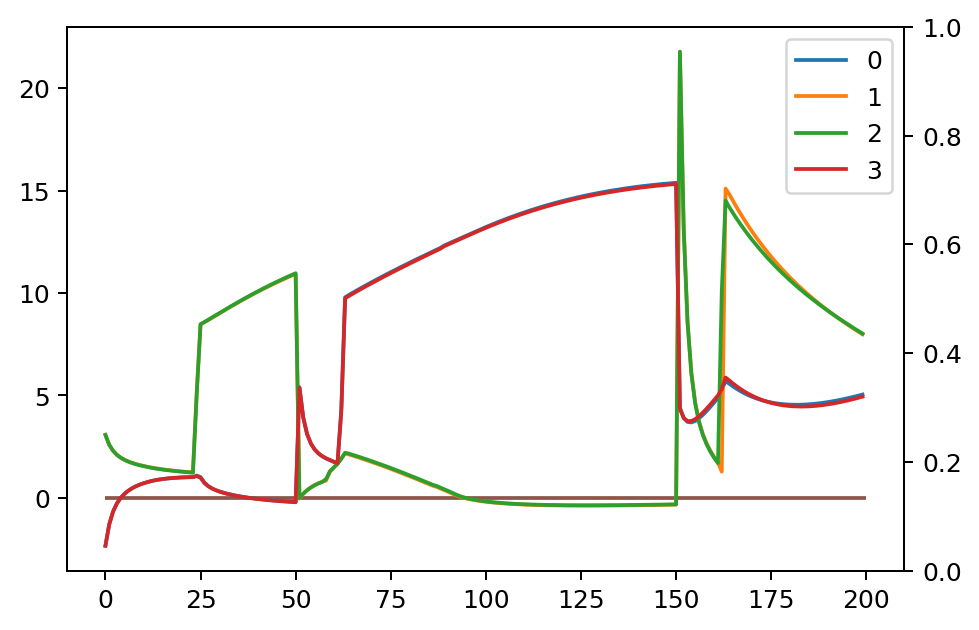

In [82]:
s = slice(0, 200)
plt.plot(grfs[s, :, 2])
# plt.hlines(2, s.start, s.stop, color='C4')
plt.hlines(0, s.start, s.stop, color='C5')
plt.legend(range(4))

t = plt.twinx()
# t.plot(qs[s, 9::3])
# t.plot(thresholds[s], '--', label='thresholds', color='C7')
# t.legend();

In [7]:
print(np.min(grfs[s, 3, 2]), np.max(grfs[np.argmin(grfs[0:100, 2, 2]):200, 2, 2]))

1.2046518315497738 9.21982194625841


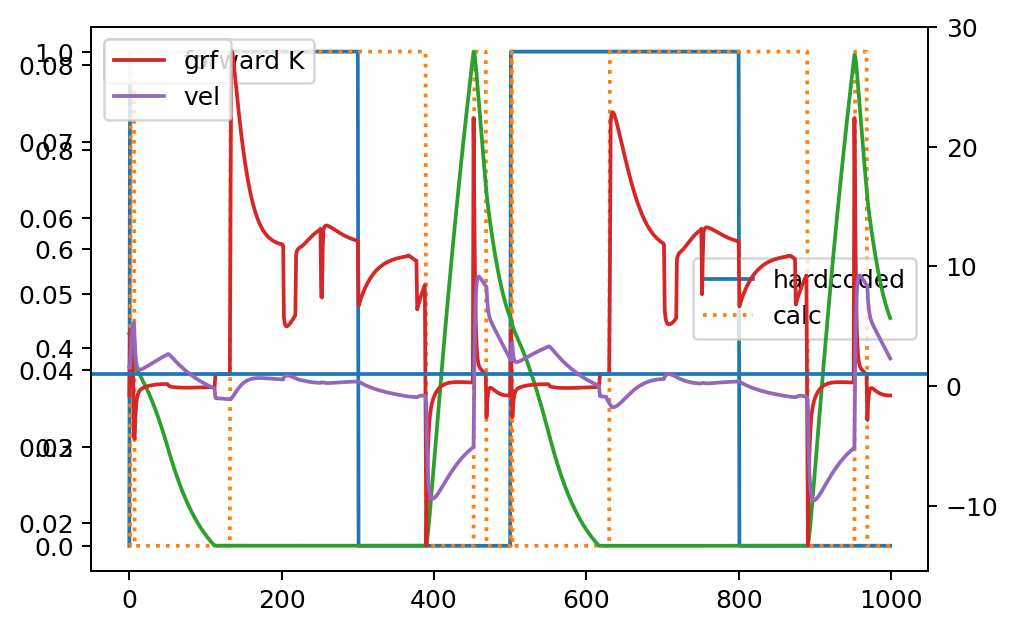

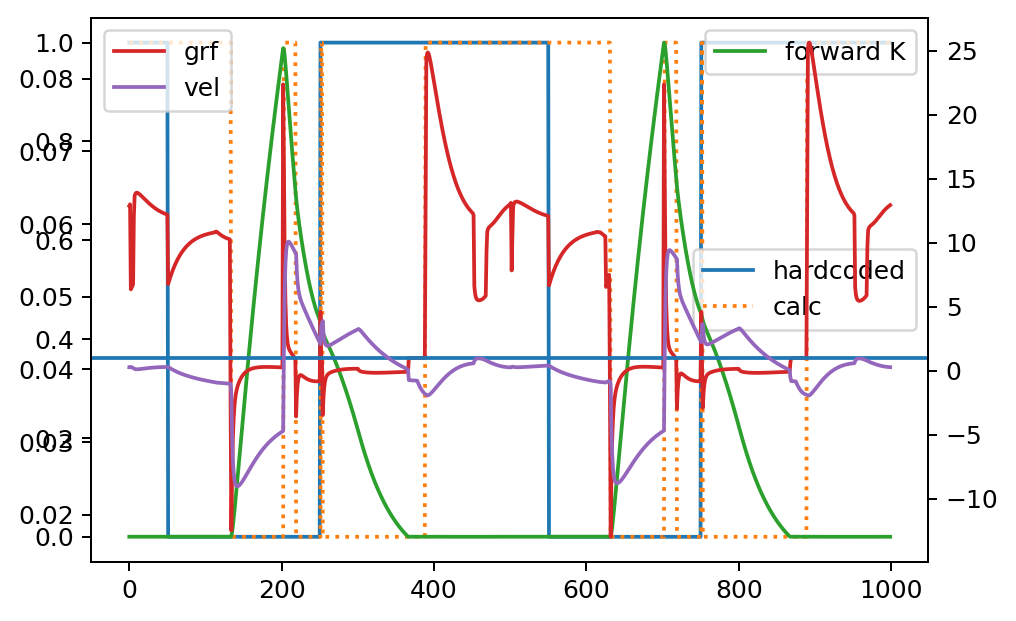

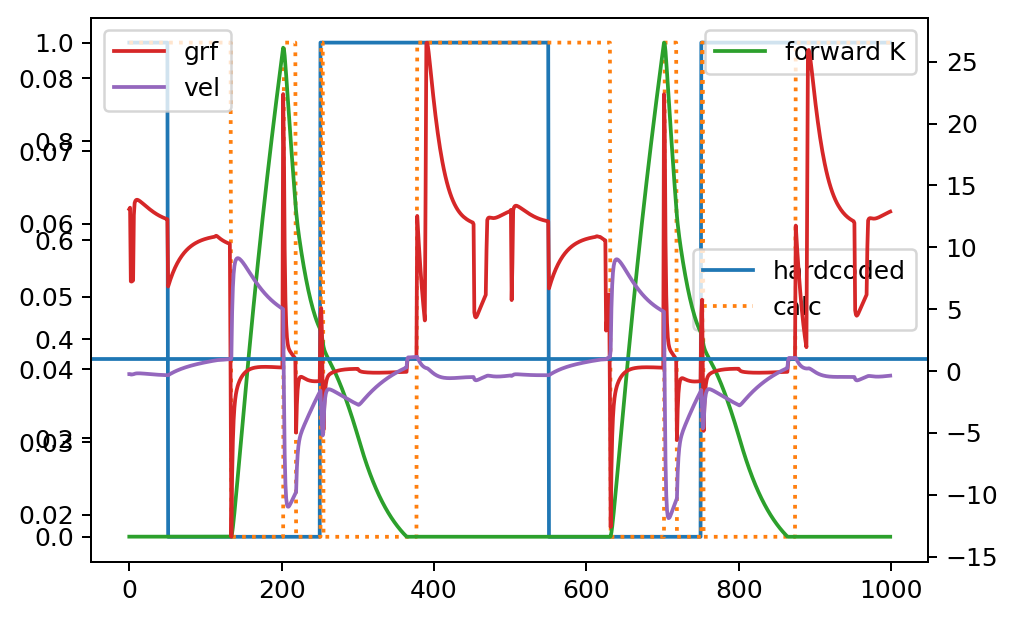

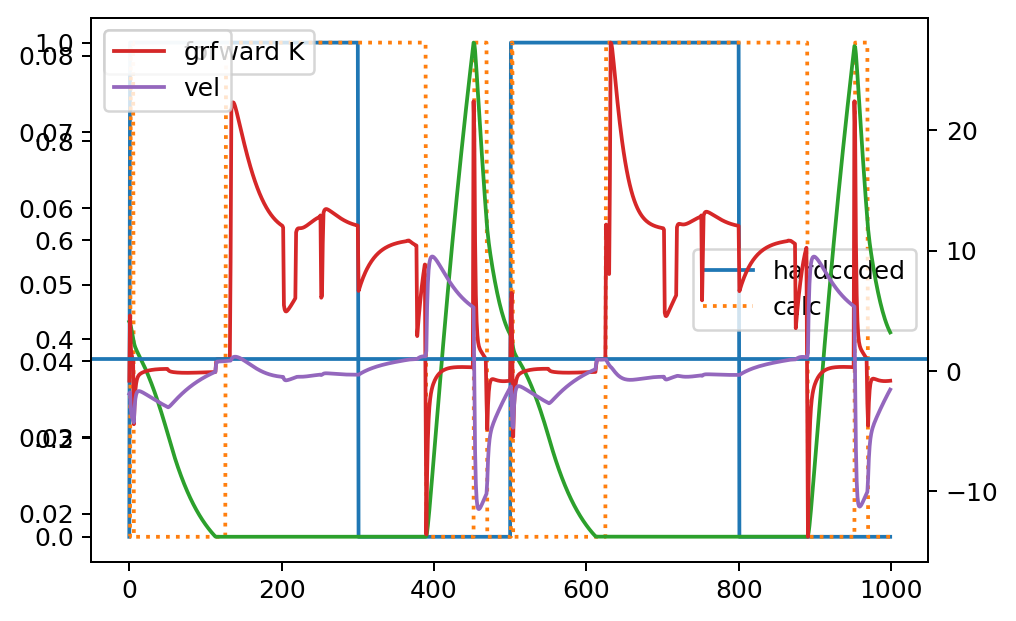

In [89]:
s = slice(1000, 2000)
for i in range(4):
    plt.plot(contact_hardcoded[s, i], label='hardcoded', color='C0')
    plt.plot(contact[s, i], ':', label='calc', color="C1")
    plt.legend()
    
    t = plt.twinx()
    t.plot(forwardKs[s, i, 2], label='forward K', color='C2')
    t.legend()
    
    w = plt.twinx()
    w.plot(grfs[s, i, 2], color="C3", label='grf')
    w.axhline(1)
#     w.plot(thresholds[s], color="C3", label='sum')
    w.plot(dqs[s, 8 + 3 * i], color='C4', label='vel')
    w.legend()
    plt.show()

(4000,)


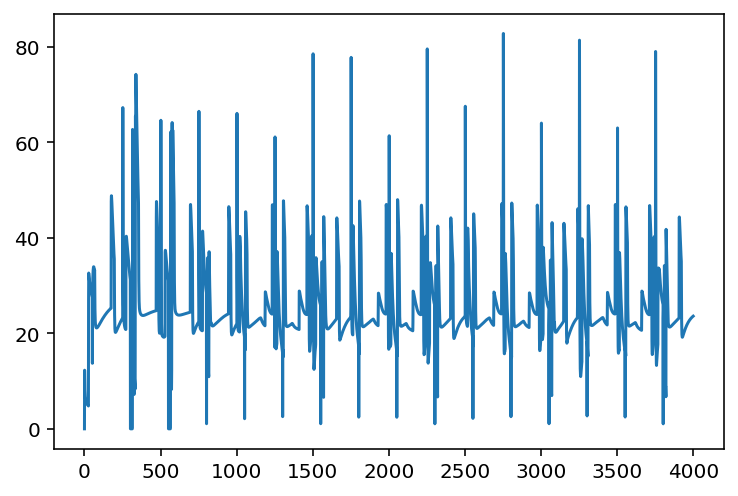

In [12]:
plt.plot(thresholds)
print(thresholds.shape)